In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.bert_conf
encoding_type = 'relative'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_relative_about'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.585621920664136 	 Validation loss: 0.4094886087765128 	 
  1%|          | 574/57400 [02:03<2:58:06,  5.32it/s]
Epoch 2 	 Training loss: 0.38388342932126246 	 Validation loss: 0.3505305867579024 	 
  2%|▏         | 1148/57400 [04:13<3:05:35,  5.05it/s]
Epoch 3 	 Training loss: 0.34455256491172603 	 Validation loss: 0.3361684599165189 	 
  3%|▎         | 1722/57400 [06:23<2:56:47,  5.25it/s]
Epoch 4 	 Training loss: 0.32353712112126864 	 Validation loss: 0.3270696439480377 	 
  4%|▍         | 2296/57400 [08:33<2:55:09,  5.24it/s]
Epoch 5 	 Training loss: 0.30974020814127207 	 Validation loss: 0.32050160710084236 	 
  5%|▌         | 2870/57400 [10:44<2:48:14,  5.40it/s]
Epoch 6 	 Training loss: 0.29658990340365765 	 Validation loss: 0.315960495653799 	 
  6%|▌         | 3444/57400 [12:54<2:48:52,  5.32it/s]
Epoch 7 	 Training loss: 0.2848953407400576 	 Validation loss: 0.3108526849645679 	 
  7%|▋         | 4018/57400 [15:01<2:24:04,  6.18it/s]
Epoch 8 	 Trainin

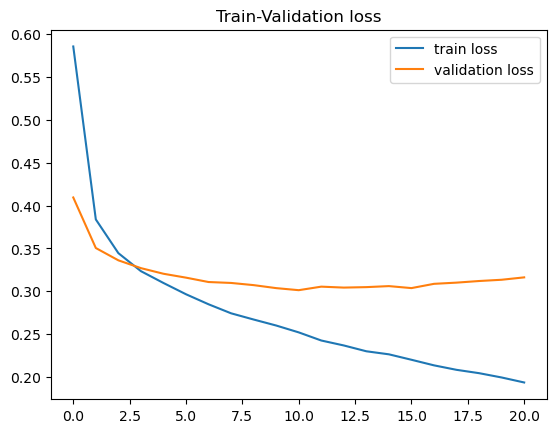

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8456632653061225, 'precision': 0.8456632653061225, 'f1': 0.8456632653061225, 'accuracy': 0.8456632653061225}
MALE {'recall': 0.8619791666666666, 'precision': 0.8619791666666666, 'f1': 0.8619791666666666, 'accuracy': 0.8619791666666666}
FEMALE {'recall': 0.83, 'precision': 0.83, 'f1': 0.83, 'accuracy': 0.83} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6843434343434344, 'precision': 0.6843434343434344, 'f1': 0.6843434343434344, 'accuracy': 0.6843434343434344}
MALE {'recall': 0.708029197080292, 'precision': 0.708029197080292, 'f1': 0.708029197080292, 'accuracy': 0.708029197080292}
FEMALE {'recall': 0.6587926509186351, 'precision': 0.6587926509186351, 'f1': 0.6587926509186351, 'accuracy': 0.6587926509186351} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6831812255541069, 'precision': 0.6831812255541069, 'f1': 0.6831812255541069, 'accuracy': 0.6831812255541069}
MALE {'recall': 0.7020202020

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5420374882761194 	 Validation loss: 0.39229413361872656 	 
  1%|          | 574/57400 [01:51<2:53:15,  5.47it/s]
Epoch 2 	 Training loss: 0.3740459354496999 	 Validation loss: 0.3481673810441615 	 
  2%|▏         | 1148/57400 [03:43<2:28:51,  6.30it/s]
Epoch 3 	 Training loss: 0.3406343556654993 	 Validation loss: 0.33497886612253674 	 
  3%|▎         | 1722/57400 [05:34<2:31:08,  6.14it/s]
Epoch 4 	 Training loss: 0.32038773996074027 	 Validation loss: 0.32147169946613957 	 
  4%|▍         | 2296/57400 [07:25<2:33:33,  5.98it/s]
Epoch 5 	 Training loss: 0.30503471211273914 	 Validation loss: 0.3154080522767568 	 
  5%|▌         | 2870/57400 [09:17<2:46:46,  5.45it/s]
Epoch 6 	 Training loss: 0.2935917116571802 	 Validation loss: 0.31330079724222926 	 
  6%|▌         | 3444/57400 [11:09<2:27:58,  6.08it/s]
Epoch 7 	 Training loss: 0.28288053596580487 	 Validation loss: 0.3048894905437857 	 
  7%|▋         | 4018/57400 [13:00<2:44:44,  5.40it/s]
Epoch 8 	 Trai

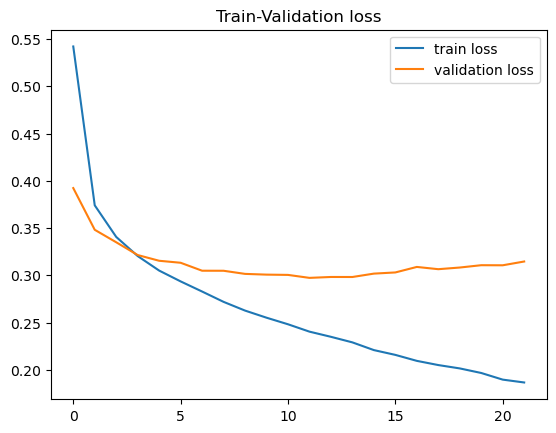

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_relative_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8469387755102041, 'precision': 0.8469387755102041, 'f1': 0.8469387755102041, 'accuracy': 0.8469387755102041}
MALE {'recall': 0.8541666666666666, 'precision': 0.8541666666666666, 'f1': 0.8541666666666666, 'accuracy': 0.8541666666666666}
FEMALE {'recall': 0.84, 'precision': 0.84, 'f1': 0.8399999999999999, 'accuracy': 0.84} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6830808080808081, 'precision': 0.6830808080808081, 'f1': 0.6830808080808081, 'accuracy': 0.6830808080808081}
MALE {'recall': 0.7007299270072993, 'precision': 0.7007299270072993, 'f1': 0.7007299270072993, 'accuracy': 0.7007299270072993}
FEMALE {'recall': 0.6640419947506562, 'precision': 0.6640419947506562, 'f1': 0.6640419947506562, 'accuracy': 0.6640419947506562} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6883963494132985, 'precision': 0.6883963494132985, 'f1': 0.6883963494132985, 'accuracy': 0.6883963494132985}
MALE {'rec

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5750101607435671 	 Validation loss: 0.41446270376948985 	 
  1%|          | 574/57400 [01:51<2:31:53,  6.24it/s]
Epoch 2 	 Training loss: 0.38593103360215963 	 Validation loss: 0.3523268285444227 	 
  2%|▏         | 1148/57400 [03:43<2:25:59,  6.42it/s]
Epoch 3 	 Training loss: 0.3450504687033879 	 Validation loss: 0.33596302089044605 	 
  3%|▎         | 1722/57400 [05:34<2:30:09,  6.18it/s]
Epoch 4 	 Training loss: 0.32479358944743353 	 Validation loss: 0.3248389711824514 	 
  4%|▍         | 2296/57400 [07:25<2:22:57,  6.42it/s]
Epoch 5 	 Training loss: 0.3110057543638691 	 Validation loss: 0.3172848760071447 	 
  5%|▌         | 2870/57400 [09:16<2:25:37,  6.24it/s]
Epoch 6 	 Training loss: 0.29557399501057036 	 Validation loss: 0.3134911638700356 	 
  6%|▌         | 3444/57400 [11:08<2:29:07,  6.03it/s]
Epoch 7 	 Training loss: 0.2850665997077779 	 Validation loss: 0.30690229823023585 	 
  7%|▋         | 4018/57400 [13:00<2:25:05,  6.13it/s]
Epoch 8 	 Train

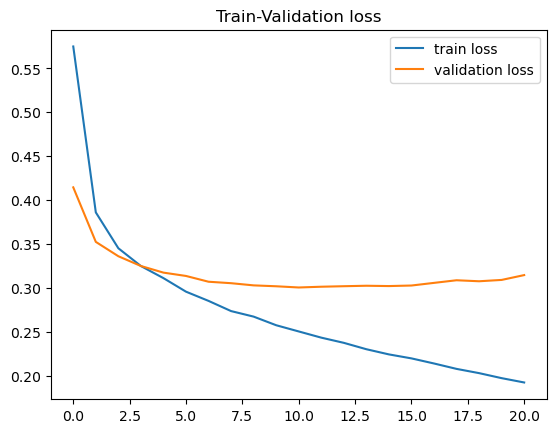

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_relative_about3'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8545918367346939, 'precision': 0.8545918367346939, 'f1': 0.8545918367346939, 'accuracy': 0.8545918367346939}
MALE {'recall': 0.8723958333333334, 'precision': 0.8723958333333334, 'f1': 0.8723958333333334, 'accuracy': 0.8723958333333334}
FEMALE {'recall': 0.8375, 'precision': 0.8375, 'f1': 0.8375, 'accuracy': 0.8375} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.678030303030303, 'precision': 0.678030303030303, 'f1': 0.678030303030303, 'accuracy': 0.678030303030303}
MALE {'recall': 0.708029197080292, 'precision': 0.708029197080292, 'f1': 0.708029197080292, 'accuracy': 0.708029197080292}
FEMALE {'recall': 0.6456692913385826, 'precision': 0.6456692913385826, 'f1': 0.6456692913385826, 'accuracy': 0.6456692913385826} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.681877444589309, 'precision': 0.681877444589309, 'f1': 0.681877444589309, 'accuracy': 0.681877444589309}
MALE {'recall': 0.7020202020

Resultados finales

In [23]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.8490646258503401, 'precision': 0.8490646258503401, 'f1': 0.8490646258503401, 'accuracy': 0.8490646258503401}
Métricas etiqueta male: {'recall': 0.8628472222222222, 'precision': 0.8628472222222222, 'f1': 0.8628472222222222, 'accuracy': 0.8628472222222222}
Métricas etiqueta female:  {'recall': 0.8358333333333333, 'precision': 0.8358333333333333, 'f1': 0.8358333333333333, 'accuracy': 0.8358333333333333}

 to
Resultado global: {'recall': 0.6818181818181818, 'precision': 0.6818181818181818, 'f1': 0.6818181818181818, 'accuracy': 0.6818181818181818}
Métricas etiqueta male: {'recall': 0.7055961070559611, 'precision': 0.7055961070559611, 'f1': 0.7055961070559611, 'accuracy': 0.7055961070559611}
Métricas etiqueta female:  {'recall': 0.6561679790026247, 'precision': 0.6561679790026247, 'f1': 0.6561679790026247, 'accuracy': 0.6561679790026247}

 as
Resultado global: {'recall': 0.6844850065189048, 'precision': 0.6844850065189048, 'f1': 0.6

# TO

In [24]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6955601928126106 	 Validation loss: 0.6925845701815718 	 
  1%|          | 574/57400 [01:51<2:50:33,  5.55it/s]
Epoch 2 	 Training loss: 0.6949778170120425 	 Validation loss: 0.6932029592788825 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:44<2:41:07,  5.82it/s]
Epoch 3 	 Training loss: 0.6937276217372575 	 Validation loss: 0.6938936649742773 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [05:36<2:40:34,  5.78it/s]
Epoch 4 	 Training loss: 0.693592783777556 	 Validation loss: 0.692269434363155 	 
  4%|▍         | 2296/57400 [07:29<2:29:24,  6.15it/s]
Epoch 5 	 Training loss: 0.6934958161585006 	 Validation loss: 0.6947664628594609 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [09:21<2:27:59,  6.14it/s]
Epoch 6 	 Training loss: 0.6929379403591156 	 Validation loss: 0.6923770823721158 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [11:13<2:39:38,  5.63it/s]
Epoch 7 	 Training loss: 0.6933916616107528 	 V

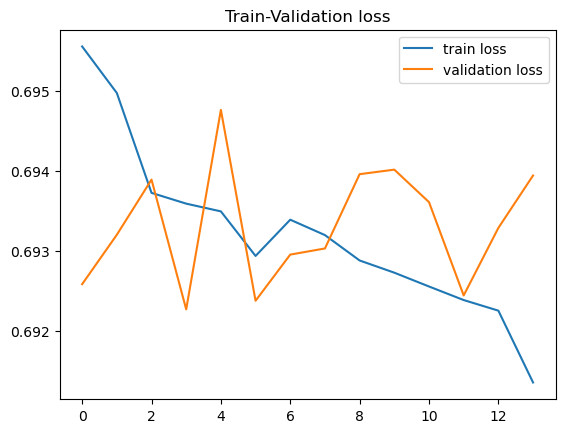

In [25]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_relative_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [26]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5625, 'precision': 0.5625, 'f1': 0.5625, 'accuracy': 0.5625}
MALE {'recall': 0.3541666666666667, 'precision': 0.3541666666666667, 'f1': 0.3541666666666667, 'accuracy': 0.3541666666666667}
FEMALE {'recall': 0.7625, 'precision': 0.7625, 'f1': 0.7625, 'accuracy': 0.7625} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5176767676767676, 'precision': 0.5176767676767676, 'f1': 0.5176767676767676, 'accuracy': 0.5176767676767676}
MALE {'recall': 0.41362530413625304, 'precision': 0.41362530413625304, 'f1': 0.41362530413625304, 'accuracy': 0.41362530413625304}
FEMALE {'recall': 0.6299212598425197, 'precision': 0.6299212598425197, 'f1': 0.6299212598425197, 'accuracy': 0.6299212598425197} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.559322033898305, 'precision': 0.559322033898305, 'f1': 0.559322033898305, 'accuracy': 0.559322033898305}
MALE {'recall': 0.4065656565656566, 'precision': 0.4065656565656

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6953746449033558 	 Validation loss: 0.6942788594860142 	 
  1%|          | 574/57400 [01:52<2:29:53,  6.32it/s]
Epoch 2 	 Training loss: 0.6948679064624401 	 Validation loss: 0.6941523784298008 	 
  2%|▏         | 1148/57400 [03:44<2:54:50,  5.36it/s]
Epoch 3 	 Training loss: 0.6941399909685713 	 Validation loss: 0.6938461974515753 	 
  3%|▎         | 1722/57400 [05:37<3:14:47,  4.76it/s]
Epoch 4 	 Training loss: 0.6938530533778958 	 Validation loss: 0.6936489838664814 	 
  4%|▍         | 2296/57400 [07:29<2:25:35,  6.31it/s]
Epoch 5 	 Training loss: 0.6936460193441305 	 Validation loss: 0.693026760877189 	 
  5%|▌         | 2870/57400 [09:21<2:24:56,  6.27it/s]
Epoch 6 	 Training loss: 0.6933287526464629 	 Validation loss: 0.6930876414654619 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [11:13<3:11:37,  4.69it/s]
Epoch 7 	 Training loss: 0.6934605216938444 	 Validation loss: 0.6932503106230397 	 

2 epoch without improvement
  7%|▋         | 40

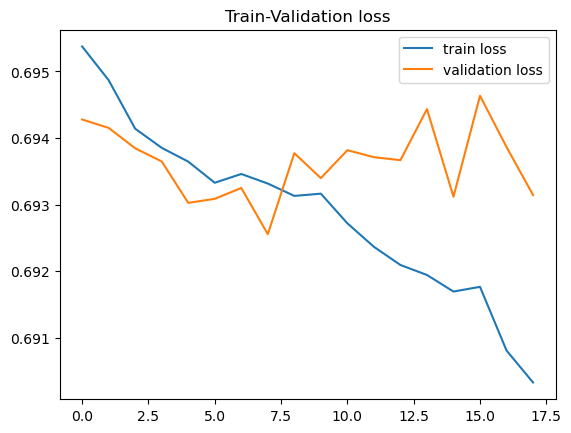

In [27]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_relative_to2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [28]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5548469387755102, 'precision': 0.5548469387755102, 'f1': 0.5548469387755102, 'accuracy': 0.5548469387755102}
MALE {'recall': 0.2552083333333333, 'precision': 0.2552083333333333, 'f1': 0.2552083333333333, 'accuracy': 0.2552083333333333}
FEMALE {'recall': 0.8425, 'precision': 0.8425, 'f1': 0.8425, 'accuracy': 0.8425} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5555555555555556, 'precision': 0.5555555555555556, 'f1': 0.5555555555555556, 'accuracy': 0.5555555555555556}
MALE {'recall': 0.27007299270072993, 'precision': 0.27007299270072993, 'f1': 0.27007299270072993, 'accuracy': 0.27007299270072993}
FEMALE {'recall': 0.863517060367454, 'precision': 0.863517060367454, 'f1': 0.863517060367454, 'accuracy': 0.863517060367454} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5332464146023468, 'precision': 0.5332464146023468, 'f1': 0.5332464146023468, 'accuracy': 0.5332464146023468}
MALE {'recall': 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6953837783286796 	 Validation loss: 0.6940858071133241 	 
  1%|          | 574/57400 [01:50<2:48:14,  5.63it/s]
Epoch 2 	 Training loss: 0.6942752794936974 	 Validation loss: 0.6927969698178567 	 
  2%|▏         | 1148/57400 [03:40<2:45:12,  5.67it/s]
Epoch 3 	 Training loss: 0.6939262605502631 	 Validation loss: 0.6925847883951866 	 
  3%|▎         | 1722/57400 [05:30<2:41:42,  5.74it/s]
Epoch 4 	 Training loss: 0.6936968851587914 	 Validation loss: 0.6927054766881264 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [07:20<2:30:17,  6.11it/s]
Epoch 5 	 Training loss: 0.6934231082529141 	 Validation loss: 0.6946597099304199 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [09:10<2:30:15,  6.05it/s]
Epoch 6 	 Training loss: 0.6930749557574867 	 Validation loss: 0.6934840305376861 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [11:00<2:23:18,  6.28it/s]
Epoch 7 	 Training loss: 0.6929579376135969 	 Validation loss: 0.692362473

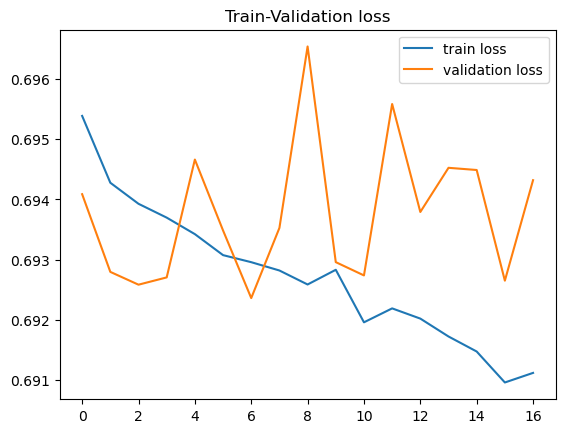

In [29]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_relative_to3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [30]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5, 'precision': 0.5, 'f1': 0.5, 'accuracy': 0.5}
MALE {'recall': 0.40625, 'precision': 0.40625, 'f1': 0.40625, 'accuracy': 0.40625}
FEMALE {'recall': 0.59, 'precision': 0.59, 'f1': 0.59, 'accuracy': 0.59} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5391414141414141, 'precision': 0.5391414141414141, 'f1': 0.5391414141414141, 'accuracy': 0.5391414141414141}
MALE {'recall': 0.40145985401459855, 'precision': 0.40145985401459855, 'f1': 0.40145985401459855, 'accuracy': 0.40145985401459855}
FEMALE {'recall': 0.6876640419947506, 'precision': 0.6876640419947506, 'f1': 0.6876640419947506, 'accuracy': 0.6876640419947506} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5345501955671447, 'precision': 0.5345501955671447, 'f1': 0.5345501955671447, 'accuracy': 0.5345501955671447}
MALE {'recall': 0.45202020202020204, 'precision': 0.45202020202020204, 'f1': 0.45202020202020204, 'accuracy': 0.452020202020

Resultados finales

In [31]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.5391156462585034, 'precision': 0.5391156462585034, 'f1': 0.5391156462585034, 'accuracy': 0.5391156462585034}
Métricas etiqueta male: {'recall': 0.3385416666666667, 'precision': 0.3385416666666667, 'f1': 0.3385416666666667, 'accuracy': 0.3385416666666667}
Métricas etiqueta female:  {'recall': 0.7316666666666667, 'precision': 0.7316666666666667, 'f1': 0.7316666666666667, 'accuracy': 0.7316666666666667}

 to
Resultado global: {'recall': 0.5374579124579124, 'precision': 0.5374579124579124, 'f1': 0.5374579124579124, 'accuracy': 0.5374579124579124}
Métricas etiqueta male: {'recall': 0.36171938361719386, 'precision': 0.36171938361719386, 'f1': 0.36171938361719386, 'accuracy': 0.36171938361719386}
Métricas etiqueta female:  {'recall': 0.7270341207349081, 'precision': 0.7270341207349081, 'f1': 0.7270341207349081, 'accuracy': 0.7270341207349081}

 as
Resultado global: {'recall': 0.5423728813559322, 'precision': 0.5423728813559322, 'f1':

# AS

In [32]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6961377248531435 	 Validation loss: 0.6924434284032401 	 
  1%|          | 574/57400 [01:50<2:54:11,  5.44it/s]
Epoch 2 	 Training loss: 0.6937654082783423 	 Validation loss: 0.6921193215806606 	 
  2%|▏         | 1148/57400 [03:40<2:31:27,  6.19it/s]
Epoch 3 	 Training loss: 0.6929684159855394 	 Validation loss: 0.6918798109232369 	 
  3%|▎         | 1722/57400 [05:31<2:57:51,  5.22it/s]
Epoch 4 	 Training loss: 0.6920387355500397 	 Validation loss: 0.6907749186127873 	 
  4%|▍         | 2296/57400 [07:21<2:31:18,  6.07it/s]
Epoch 5 	 Training loss: 0.6907104880967622 	 Validation loss: 0.6898746844065391 	 
  5%|▌         | 2870/57400 [09:12<2:22:55,  6.36it/s]
Epoch 6 	 Training loss: 0.6891838272689527 	 Validation loss: 0.6930558146056482 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [11:02<2:24:40,  6.22it/s]
Epoch 7 	 Training loss: 0.6881776900656963 	 Validation loss: 0.6922667097237151 	 

2 epoch without improvement
  7%|▋         | 4

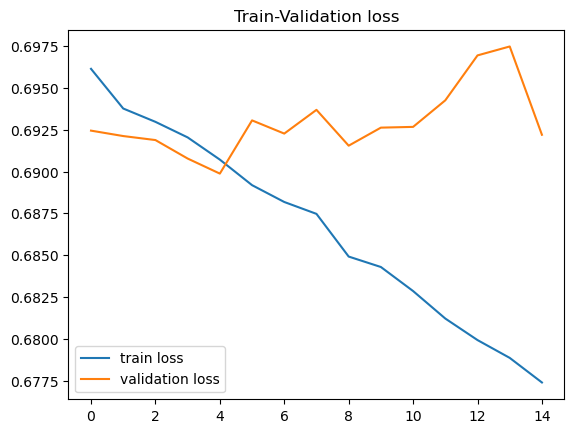

In [33]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_relative_as'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [34]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6339285714285714, 'precision': 0.6339285714285714, 'f1': 0.6339285714285714, 'accuracy': 0.6339285714285714}
MALE {'recall': 0.5390625, 'precision': 0.5390625, 'f1': 0.5390625, 'accuracy': 0.5390625}
FEMALE {'recall': 0.725, 'precision': 0.725, 'f1': 0.7250000000000001, 'accuracy': 0.725} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6212121212121212, 'precision': 0.6212121212121212, 'f1': 0.6212121212121212, 'accuracy': 0.6212121212121212}
MALE {'recall': 0.5498783454987834, 'precision': 0.5498783454987834, 'f1': 0.5498783454987834, 'accuracy': 0.5498783454987834}
FEMALE {'recall': 0.6981627296587927, 'precision': 0.6981627296587927, 'f1': 0.6981627296587927, 'accuracy': 0.6981627296587927} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6179921773142112, 'precision': 0.6179921773142112, 'f1': 0.6179921773142112, 'accuracy': 0.6179921773142112}
MALE {'recall': 0.5025252525252525, 'precis

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6947511237257449 	 Validation loss: 0.6948284415875451 	 
  1%|          | 574/57400 [01:49<2:37:42,  6.01it/s]
Epoch 2 	 Training loss: 0.6935815781043382 	 Validation loss: 0.6937753548056392 	 
  2%|▏         | 1148/57400 [03:39<2:29:56,  6.25it/s]
Epoch 3 	 Training loss: 0.6927472021729273 	 Validation loss: 0.6932967527438019 	 
  3%|▎         | 1722/57400 [05:29<2:43:46,  5.67it/s]
Epoch 4 	 Training loss: 0.6915806846543887 	 Validation loss: 0.6914708594144401 	 
  4%|▍         | 2296/57400 [07:20<2:25:29,  6.31it/s]
Epoch 5 	 Training loss: 0.6902649342390719 	 Validation loss: 0.6925558518555205 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [09:09<2:28:22,  6.13it/s]
Epoch 6 	 Training loss: 0.6885885487242442 	 Validation loss: 0.6924729357331486 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [10:58<2:27:45,  6.09it/s]
Epoch 7 	 Training loss: 0.6869348862860676 	 Validation loss: 0.6927330928333735 	 

3 epoch without i

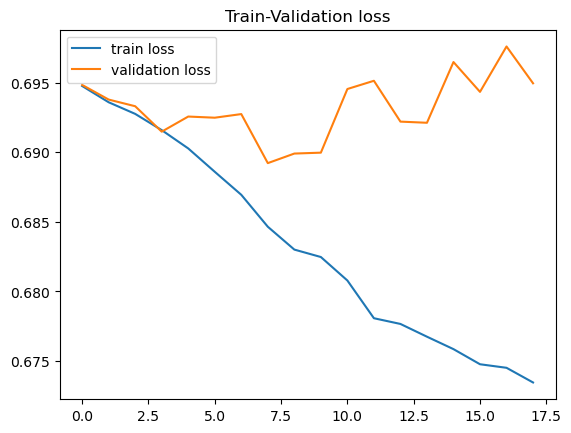

In [35]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_relative_as2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [36]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6721938775510204, 'precision': 0.6721938775510204, 'f1': 0.6721938775510204, 'accuracy': 0.6721938775510204}
MALE {'recall': 0.6015625, 'precision': 0.6015625, 'f1': 0.6015625, 'accuracy': 0.6015625}
FEMALE {'recall': 0.74, 'precision': 0.74, 'f1': 0.74, 'accuracy': 0.74} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.648989898989899, 'precision': 0.648989898989899, 'f1': 0.648989898989899, 'accuracy': 0.648989898989899}
MALE {'recall': 0.6058394160583942, 'precision': 0.6058394160583942, 'f1': 0.6058394160583942, 'accuracy': 0.6058394160583942}
FEMALE {'recall': 0.6955380577427821, 'precision': 0.6955380577427821, 'f1': 0.6955380577427821, 'accuracy': 0.6955380577427821} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7183833116036505, 'precision': 0.7183833116036505, 'f1': 0.7183833116036505, 'accuracy': 0.7183833116036505}
MALE {'recall': 0.6186868686868687, 'precision': 0.6186868686868

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.695398241593032 	 Validation loss: 0.6926392256203344 	 
  1%|          | 574/57400 [02:17<3:28:09,  4.55it/s]
Epoch 2 	 Training loss: 0.6942470006203402 	 Validation loss: 0.6925841196108673 	 
  2%|▏         | 1148/57400 [04:45<2:58:41,  5.25it/s]
Epoch 3 	 Training loss: 0.6931707632666265 	 Validation loss: 0.6904699256864645 	 
  3%|▎         | 1722/57400 [06:57<2:46:03,  5.59it/s]
Epoch 4 	 Training loss: 0.6915521302912708 	 Validation loss: 0.6926903916617572 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [09:03<2:41:29,  5.69it/s]
Epoch 5 	 Training loss: 0.6902728116055399 	 Validation loss: 0.6903905030024253 	 
  5%|▌         | 2870/57400 [11:15<2:52:38,  5.26it/s]
Epoch 6 	 Training loss: 0.6885040013009247 	 Validation loss: 0.691509975215136 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [13:30<3:22:23,  4.44it/s]
Epoch 7 	 Training loss: 0.6886114537300548 	 Validation loss: 0.690659504825786 	 

2 epoch without impr

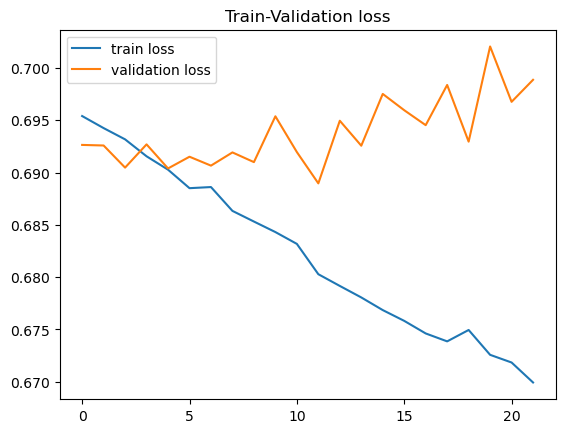

In [37]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='bert_relative_as3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [38]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6581632653061225, 'precision': 0.6581632653061225, 'f1': 0.6581632653061225, 'accuracy': 0.6581632653061225}
MALE {'recall': 0.578125, 'precision': 0.578125, 'f1': 0.578125, 'accuracy': 0.578125}
FEMALE {'recall': 0.735, 'precision': 0.735, 'f1': 0.735, 'accuracy': 0.735} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6477272727272727, 'precision': 0.6477272727272727, 'f1': 0.6477272727272727, 'accuracy': 0.6477272727272727}
MALE {'recall': 0.635036496350365, 'precision': 0.635036496350365, 'f1': 0.635036496350365, 'accuracy': 0.635036496350365}
FEMALE {'recall': 0.6614173228346457, 'precision': 0.6614173228346457, 'f1': 0.6614173228346457, 'accuracy': 0.6614173228346457} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7014341590612777, 'precision': 0.7014341590612777, 'f1': 0.7014341590612777, 'accuracy': 0.7014341590612777}
MALE {'recall': 0.6237373737373737, 'precision': 0.6237373737373

Resultados finales

In [39]:
print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})

Métricas globales: 


 about
Resultado global: {'recall': 0.6547619047619048, 'precision': 0.6547619047619048, 'f1': 0.6547619047619048, 'accuracy': 0.6547619047619048}
Métricas etiqueta male: {'recall': 0.5729166666666666, 'precision': 0.5729166666666666, 'f1': 0.5729166666666666, 'accuracy': 0.5729166666666666}
Métricas etiqueta female:  {'recall': 0.7333333333333333, 'precision': 0.7333333333333333, 'f1': 0.7333333333333334, 'accuracy': 0.7333333333333333}

 to
Resultado global: {'recall': 0.6393097643097643, 'precision': 0.6393097643097643, 'f1': 0.6393097643097643, 'accuracy': 0.6393097643097643}
Métricas etiqueta male: {'recall': 0.5969180859691808, 'precision': 0.5969180859691808, 'f1': 0.5969180859691808, 'accuracy': 0.5969180859691808}
Métricas etiqueta female:  {'recall': 0.6850393700787402, 'precision': 0.6850393700787402, 'f1': 0.6850393700787402, 'accuracy': 0.6850393700787402}

 as
Resultado global: {'recall': 0.6792698826597131, 'precision': 0.6792698826597131, 'f1': 0.6